In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [223]:
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

data = []

for month in months:
    data.append(pd.read_csv(f'data{month}-2017.csv'))
data = pd.concat(data)

In [225]:
data = data.filter(regex='pm10', axis=1).to_numpy()

In [276]:
data.shape

(8593, 56)

In [218]:
sensors = pd.read_csv('data/sensor_locations.csv')
sensors = sensors.to_numpy()[:, [1, 2]]

In [262]:
from geopy.distance import distance as geo_dist
from scipy.spatial.distance import cdist
dist_mat = cdist(sensors, sensors, metric=lambda a,b: geo_dist(a, b).km)
np.fill_diagonal(dist_mat, 1)

In [263]:
def idw_point(inv_p_dist_mat, p_idx, ps_ids, weights, p):
    W = inv_p_dist_mat[p_idx, ps_ids]
    A = np.dot(weights, W)
    B = np.sum(W)
    return A / B

In [296]:
from sklearn.model_selection import ShuffleSplit

def test_idw(inv_p_dist_mat, points, weights, p=2):
    proper = ~( np.isnan(weights) | (weights == 0))
    points = points[proper]
    weights = weights[proper]
    ss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
    train, test = next(ss.split(np.arange(points.shape[0])))
    idw = lambda p_idx: idw_point(inv_p_dist_mat, p_idx, ps_ids = train, weights=weights[train], p=p)
    res = np.apply_along_axis(idw, 1, test[:, np.newaxis])
    return np.mean(( np.abs(res - weights[test]) / weights[test] ))
    

In [290]:
def test_idw_whole(data, points, p=2):
    inv_p_dist_mat = 1 / dist_mat ** p
    idw = lambda weights: test_idw(inv_p_dist_mat=inv_p_dist_mat, points=points, weights=weights, p=p)
    return np.apply_along_axis(idw, 1, data)

In [280]:
abs_err = test_idw_whole(data, sensors, p=2)

In [269]:
%matplotlib notebook

In [270]:
from mpmath import mpf, nstr

In [312]:
def hist_err(data, points, p):
    abs_err = test_idw_whole(data, sensors, p=p)
    abs_err = abs_err[abs_err <= 1]
    fig, ax = plt.subplots()
    ax.hist(abs_err, bins=100)
    fig.suptitle(f'Absolute relative error distribution, for p={p}\nmean={nstr(mpf(np.mean(abs_err)), 3)}')
    fig.tight_layout()
    plt.show()
    print(pd.DataFrame(abs_err).describe())

<IPython.core.display.Javascript object>


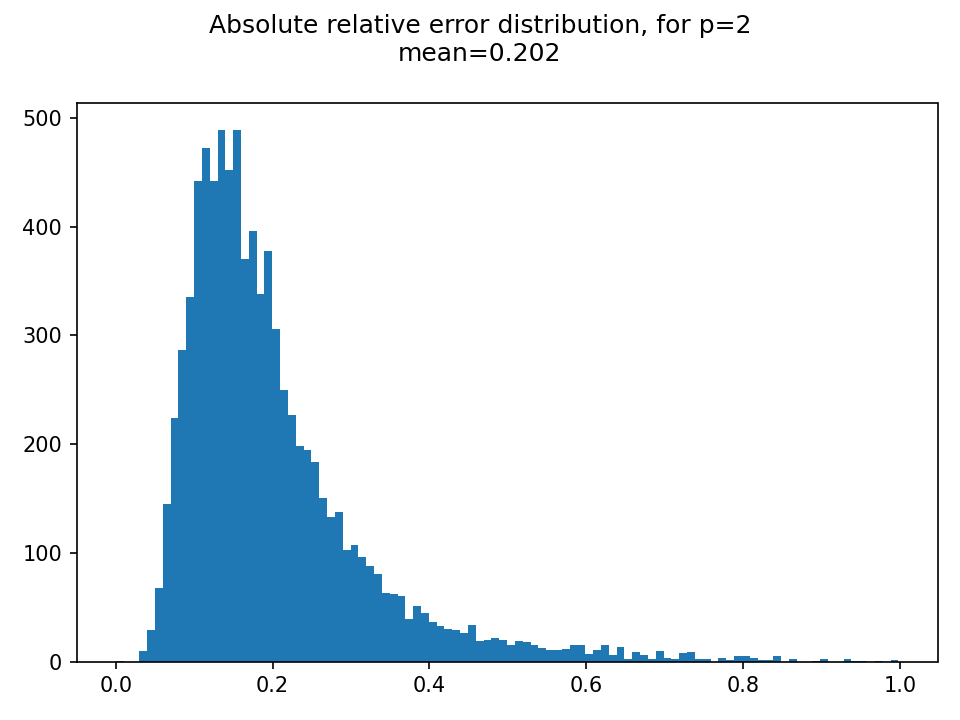

                  0
count  8.523000e+03
mean   2.020372e-01
std    1.226032e-01
min    3.700743e-17
25%    1.225358e-01
50%    1.699637e-01
75%    2.410067e-01
max    9.980439e-01


In [313]:
hist_err(data, points, p=2)

<IPython.core.display.Javascript object>


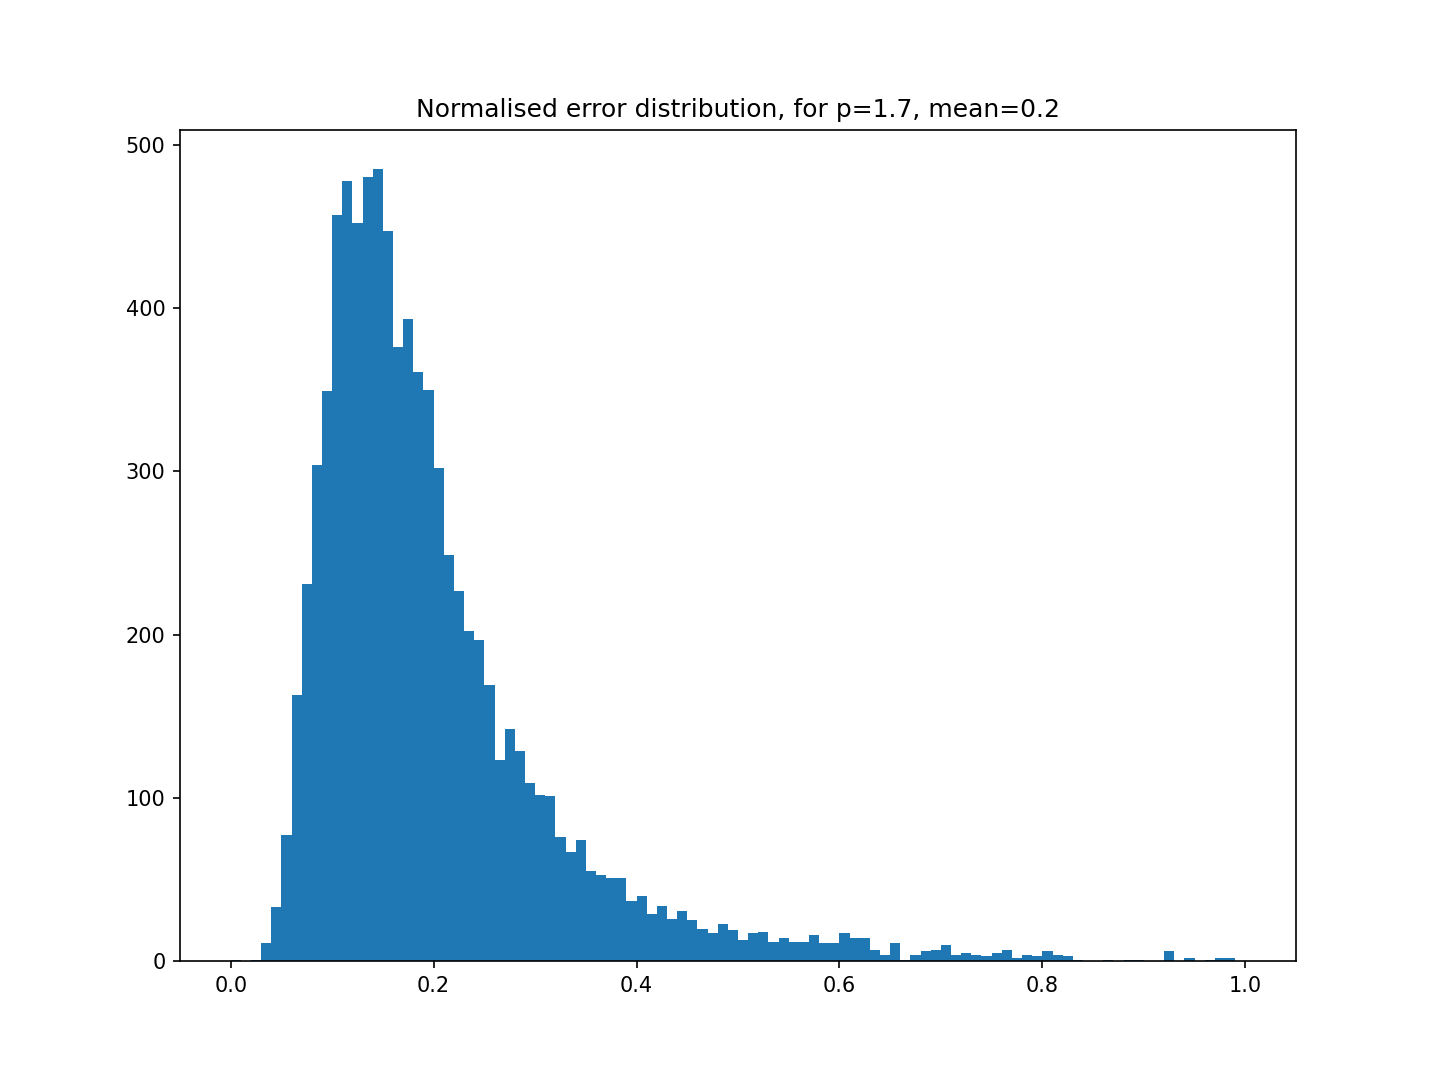

In [273]:
hist_err(data, points, p=1.7)

<IPython.core.display.Javascript object>


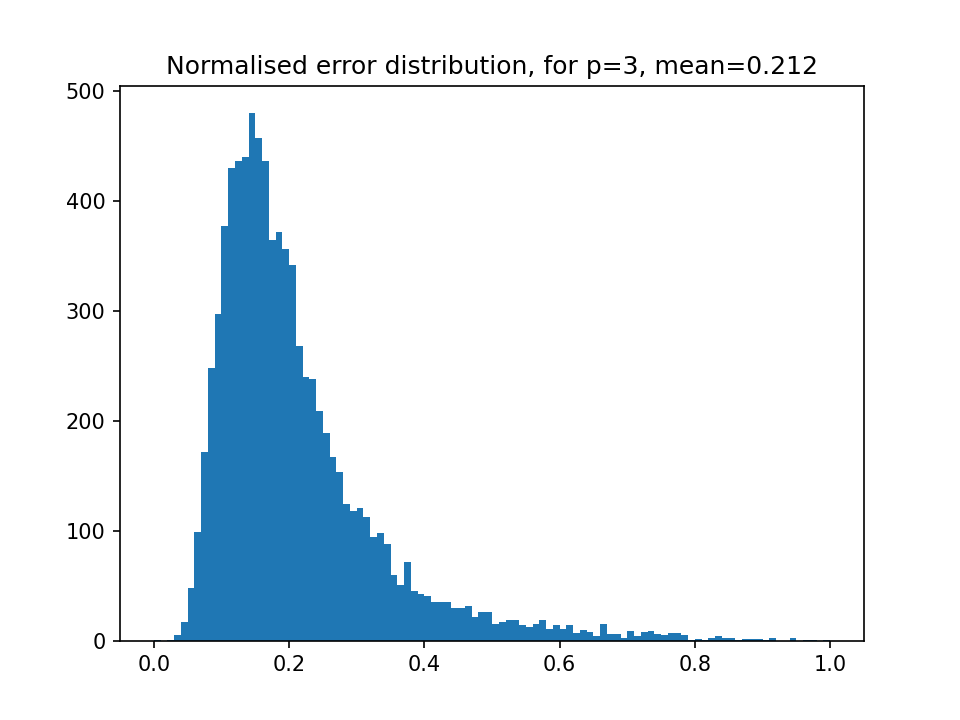

In [274]:
hist_err(data, points, p=3)

<IPython.core.display.Javascript object>


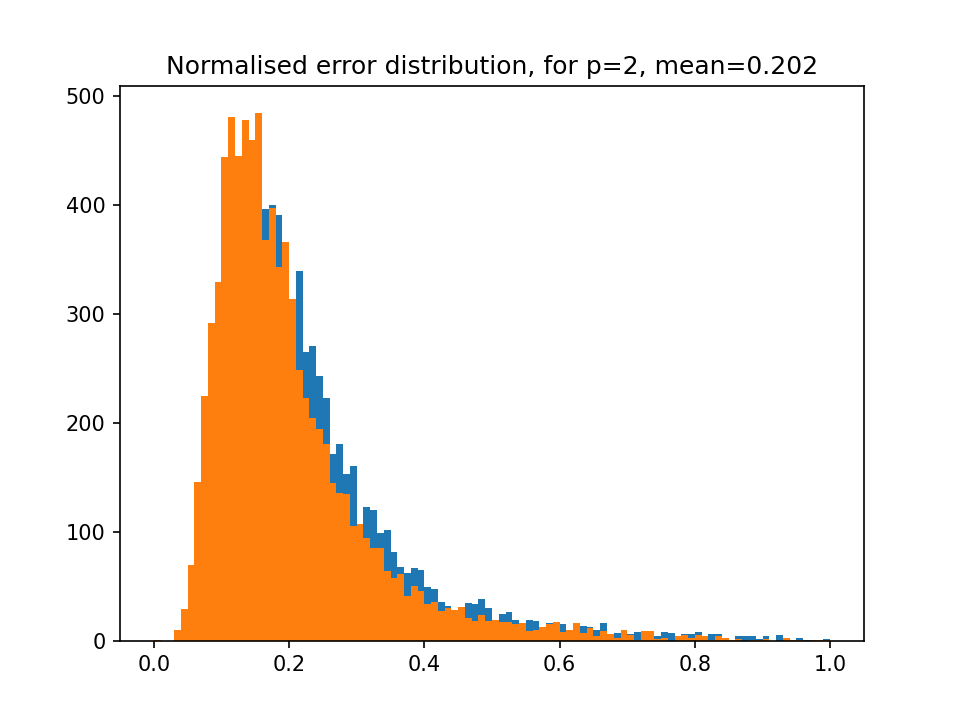

In [275]:
hist_err(data, points, p=5)